# Exploring Twitter Data from Congress Member

In [297]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
from datetime import datetime, timedelta
from pandas.io.json import json_normalize
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [298]:
plt.style.use('seaborn')

In [299]:
# define dates to get twitter data
start_date = datetime(2017,6,21)
end_date = datetime.today() - timedelta(days=1)

In [300]:
dates = [ start_date + timedelta(n) for n in range(int ((end_date - start_date).days))]

dates = pd.to_datetime(dates)
dates = dates.strftime('%Y-%m-%d')

In [301]:
# loop to collect data
df = pd.DataFrame()
for i in dates:
    url = 'https://alexlitel.github.io/congresstweets/data/' + i + '.json'
    r = requests.get(url).json()
    df = df.append(pd.DataFrame(r))   

In [302]:
df['date'] = pd.to_datetime(df.time)
df.set_index('date', inplace=True)
df.head()

,id,link,screen_name,source,text,time
date,,,,,,
2017-06-21 04:33:01,877383834240667648,https://www.twitter.com/KamalaHarris/statuses/...,KamalaHarris,Sprout Social,No public hearings. \nNo debate. \nNo text.\nN...,2017-06-21T00:33:01-04:00
2017-06-21 04:02:47,877376225664090112,https://www.twitter.com/tedlieu/statuses/87737...,tedlieu,Twitter for Android,Why should world leaders trust or listen to US...,2017-06-21T00:02:47-04:00
2017-06-21 06:00:22,877405817565306880,https://www.twitter.com/JerryNadler/statuses/8...,JerryNadler,Twitter for iPhone,Congratulations to Jon @ossoff and #GADems on ...,2017-06-21T02:00:22-04:00
2017-06-21 05:39:55,877400668411052032,https://www.twitter.com/TulsiGabbard/statuses/...,TulsiGabbard,Twitter for iPhone,Join me in celebrating the gift of yoga on thi...,2017-06-21T01:39:55-04:00
2017-06-21 06:13:27,877409109846478848,https://www.twitter.com/JerryNadler/statuses/8...,JerryNadler,Twitter for iPhone,#GA06 is #GOP stronghold &amp; @ossoff nearly ...,2017-06-21T02:13:27-04:00


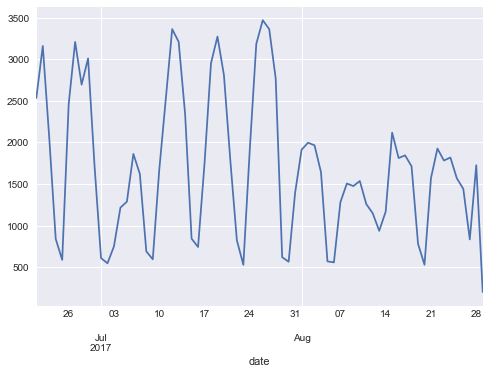

In [303]:
# number of tweets per day
df.text.resample('D').count().plot();

# Reading Metadata and Match Screen Names

In [304]:
# read metadata
url = "https://raw.githubusercontent.com/alexlitel/congresstweets-automator/master/data/users-filtered.json"
r = requests.get(url).json()

In [305]:
m = json_normalize(r)

In [306]:
m = m.loc[m.type=='member']

In [307]:
def getvalue(value):
    if (len(value) == 0):
        return None
    else:
        return value[0]['screen_name']

s = m.loc[:, 'accounts.office'].notnull()
m.loc[s, 'name1'] = m.loc[s,'accounts.office'].map(getvalue)

In [308]:
s = m.loc[:, 'accounts.campaign'].notnull()
m.loc[s, 'name2'] = m.loc[s,'accounts.campaign'].map(getvalue)

In [309]:
# exploring the results
m.head()

,accounts.campaign,accounts.office,chamber,id.bioguide,id.govtrack,id.house_committee_id,id.senate_committee_id,id.tag,id.thomas_id,name,party,state,type,name1,name2
33,"[{'id_str': '2559398984', 'screen_name': 'DonY...","[{'id_str': '37007274', 'screen_name': 'repdon...",house,Y000033,400440.0,NaN,NaN,NaN,NaN,Don Young,R,AK,member,repdonyoung,DonYoungAK
34,"[{'id_str': '42481696', 'screen_name': 'Bradle...","[{'id_str': '2253968388', 'screen_name': 'RepB...",house,B001289,412601.0,NaN,NaN,NaN,NaN,Bradley Byrne,R,AL,member,RepByrne,BradleyByrne
35,"[{'id_str': '2296943622', 'screen_name': 'Palm...","[{'id_str': '2861616083', 'screen_name': 'USRe...",house,P000609,412608.0,NaN,NaN,NaN,NaN,Gary Palmer,R,AL,member,USRepGaryPalmer,Palmer4Alabama
36,"[{'id_str': '69086398', 'screen_name': 'TeamRo...","[{'id_str': '224294785', 'screen_name': 'RepMa...",house,R000591,412394.0,NaN,NaN,NaN,NaN,Martha Roby,R,AL,member,RepMarthaRoby,TeamRoby
37,"[{'id_str': '76069325', 'screen_name': 'MikeRo...","[{'id_str': '33977070', 'screen_name': 'RepMik...",house,R000575,400341.0,NaN,NaN,NaN,NaN,Mike Rogers,R,AL,member,RepMikeRogersAL,MikeRogersCamp


In [310]:
meta = pd.melt(m, id_vars=['chamber', 'id.govtrack', 'name', 'party', 'state'], 
               value_vars=['name1', 'name2'])


In [311]:
meta.rename(columns={'value':'mnames'}, inplace=True)
meta = meta[meta.mnames.notnull()]
meta.head()

,chamber,id.govtrack,name,party,state,variable,mnames
0,house,400440.0,Don Young,R,AK,name1,repdonyoung
1,house,412601.0,Bradley Byrne,R,AL,name1,RepByrne
2,house,412608.0,Gary Palmer,R,AL,name1,USRepGaryPalmer
3,house,412394.0,Martha Roby,R,AL,name1,RepMarthaRoby
4,house,400341.0,Mike Rogers,R,AL,name1,RepMikeRogersAL


In [312]:
# explore some screen names
meta.loc[meta.mnames == 'auctnr1',:]
# meta.loc[meta.name.str.contains('Bill'),:]

,chamber,id.govtrack,name,party,state,variable,mnames
761,house,412445.0,Billy Long,R,MO,name2,auctnr1


In [313]:
choices = meta.loc[:,'mnames'].tolist()

In [314]:
queries = df.loc[:,'screen_name'].tolist()
queries = list(set(queries)) # remove duplicates

In [315]:
#[re.search(r'auctnr1', q) for q in choices]
len(queries)

900

In [316]:
t = map(lambda q : process.extractOne(q, choices, score_cutoff=80), queries)
t = list(t)

In [317]:
# extract names
names = [x[0] if x is not None else None for x in t]
score = [x[1] if x is not None else None for x in t]
# create dataframe
name_match = pd.DataFrame({'screen_name': queries,'mnames': names, 'score_match' : score})
name_match.head()

,mnames,score_match,screen_name
0,RepDwightEvans,100.0,RepDwightEvans
1,jahimes,100.0,jahimes
2,DesJarlaisTN04,100.0,DesJarlaisTN04
3,davidcicilline,100.0,davidcicilline
4,None,NaN,conversations


In [318]:
name_match = name_match[name_match.score_match.notnull()]
name_match.shape

(813, 3)

In [319]:
name_match[name_match.score_match < 100]

,mnames,score_match,screen_name
37,DevinGNunes,95.0,DevinNunes
51,MaxineWaters,89.0,RepMaxineWaters
54,RepTomEmmer,84.0,tomemmer
113,Rep_DevinNunes,96.0,RepDevinNunes
119,SenatorTomUdall,90.0,tomudall
239,RepMikeBishop,80.0,MikeBishopMI
287,RepRyanCostello,90.0,PRyan
335,JohnKDelaneyJKD,89.0,JohnKDelaney
367,TeamTedCruz,90.0,tedcruz
695,RepJaredPolis,87.0,jaredpolis


In [320]:
t = pd.merge(meta, name_match, on='mnames', how='left')
dat = pd.merge(df, t, on='screen_name', how='left')

In [321]:
dat = dat.loc[dat.mnames.notnull(),:]
len(dat.name.unique())

527

In [327]:
dat['date'] = pd.to_datetime(dat.time)
dat.set_index('date', inplace=True)
dat.loc[:, ['name', 'party', 'mnames', 'score_match']].head()

,name,party,mnames,score_match
date,,,,
2017-06-21 04:33:01,Kamala Harris,D,KamalaHarris,100.0
2017-06-21 04:02:47,Ted Lieu,D,tedlieu,100.0
2017-06-21 06:00:22,Jerrold Nadler,D,JerryNadler,100.0
2017-06-21 05:39:55,Tulsi Gabbard,D,TulsiGabbard,100.0
2017-06-21 06:13:27,Jerrold Nadler,D,JerryNadler,100.0


In [328]:
dat.loc[dat.name.str.contains('Long'), 'mnames'].value_counts() # most of cases come from auctnrl

auctnr1      3343
USRepLong      48
Name: mnames, dtype: int64

In [329]:
nt = dat.groupby('name').count().id
nt[nt > 1000]

name
Billy Long         3391
Don Beyer          1887
Pramila Jayapal    1764
Ro Khanna          1404
Name: id, dtype: int64

In [ ]:
dat.text.resample('D').count().plot();

In [ ]:
# plot distribution number of tweets per member
nt.hist(bins=100);

In [330]:
# descriptives members' tweets
dat.party.value_counts()

D    62225
R    41851
I      432
Name: party, dtype: int64

In [331]:
dat.chamber.value_counts()

house     76458
senate    28050
Name: chamber, dtype: int64